# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True,  transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True,  transform=test_transforms)

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
train_data_mean = torch.mean(train_data)
train_data_std = torch.std(train_data)
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train_data_mean)
print(' - std:', train_data_std)
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/vehere/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Display a single Digit from MNIST dataset

torch.Size([64, 1, 28, 28])
torch.Size([64])


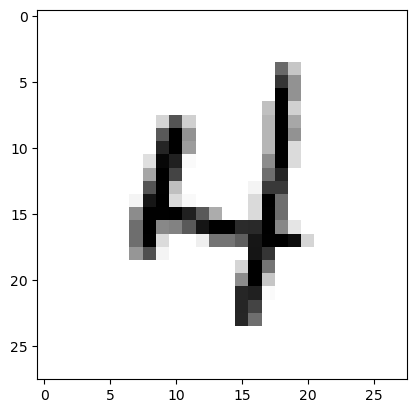

In [8]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Display an array of random images from dataset


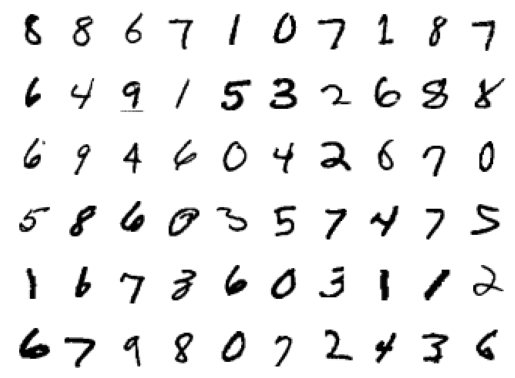

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
from model import Net3
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = Net3().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]           1,168
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 20, 14, 14]           2,900
       BatchNorm2d-7           [-1, 20, 14, 14]              40
            Conv2d-8           [-1, 24, 14, 14]           4,344
       BatchNorm2d-9           [-1, 24, 14, 14]              48
        MaxPool2d-10             [-1, 24, 7, 7]               0
           Conv2d-11             [-1, 20, 5, 5]           4,340
      BatchNorm2d-12             [-1, 20, 5, 5]              40
           Conv2d-13             [-1, 16, 3, 3]           2,896
           Conv2d-14             [-

/Users/vehere/ERA_V2/ERA_v2.0/s7/model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net2 model

In [12]:
device = torch.device("mps")
model =  Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07910575717687607 Batch_id=937 Accuracy=95.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 49.46it/s]



Test set: Average loss: 0.0581, Accuracy: 9813/10000 (98.13%)

EPOCH: 1


Loss=0.03874892741441727 Batch_id=937 Accuracy=98.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 62.65it/s]



Test set: Average loss: 0.0318, Accuracy: 9904/10000 (99.04%)

EPOCH: 2


Loss=0.00790388137102127 Batch_id=937 Accuracy=99.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.37it/s]



Test set: Average loss: 0.0333, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.006191635504364967 Batch_id=937 Accuracy=99.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.99it/s]



Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 4


Loss=0.008527977392077446 Batch_id=937 Accuracy=99.37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.94it/s]



Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.07367882132530212 Batch_id=937 Accuracy=99.48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.38it/s]



Test set: Average loss: 0.0242, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.000285511021502316 Batch_id=937 Accuracy=99.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.54it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.002611311851069331 Batch_id=937 Accuracy=99.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.59it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.0006257770583033562 Batch_id=937 Accuracy=99.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.42it/s]



Test set: Average loss: 0.0282, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.00016544251411687583 Batch_id=937 Accuracy=99.67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.75it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.015331854112446308 Batch_id=937 Accuracy=99.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.39it/s]



Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.005763511639088392 Batch_id=937 Accuracy=99.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.27it/s]



Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0518951378762722 Batch_id=937 Accuracy=99.78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 65.70it/s]



Test set: Average loss: 0.0277, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.010337425395846367 Batch_id=937 Accuracy=99.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.50it/s]



Test set: Average loss: 0.0248, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.000486910343170166 Batch_id=937 Accuracy=99.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 65.41it/s]



Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.0008983461884781718 Batch_id=937 Accuracy=99.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.44it/s]



Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=7.315300081245368e-06 Batch_id=937 Accuracy=99.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 62.47it/s]



Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.00010110762377735227 Batch_id=937 Accuracy=99.92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 65.49it/s]



Test set: Average loss: 0.0234, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=4.5412700274027884e-05 Batch_id=937 Accuracy=99.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.71it/s]



Test set: Average loss: 0.0265, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.00034671893808990717 Batch_id=937 Accuracy=99.90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.90it/s]



Test set: Average loss: 0.0255, Accuracy: 9940/10000 (99.40%)



# Train Vs Test Loss Plot

In [13]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

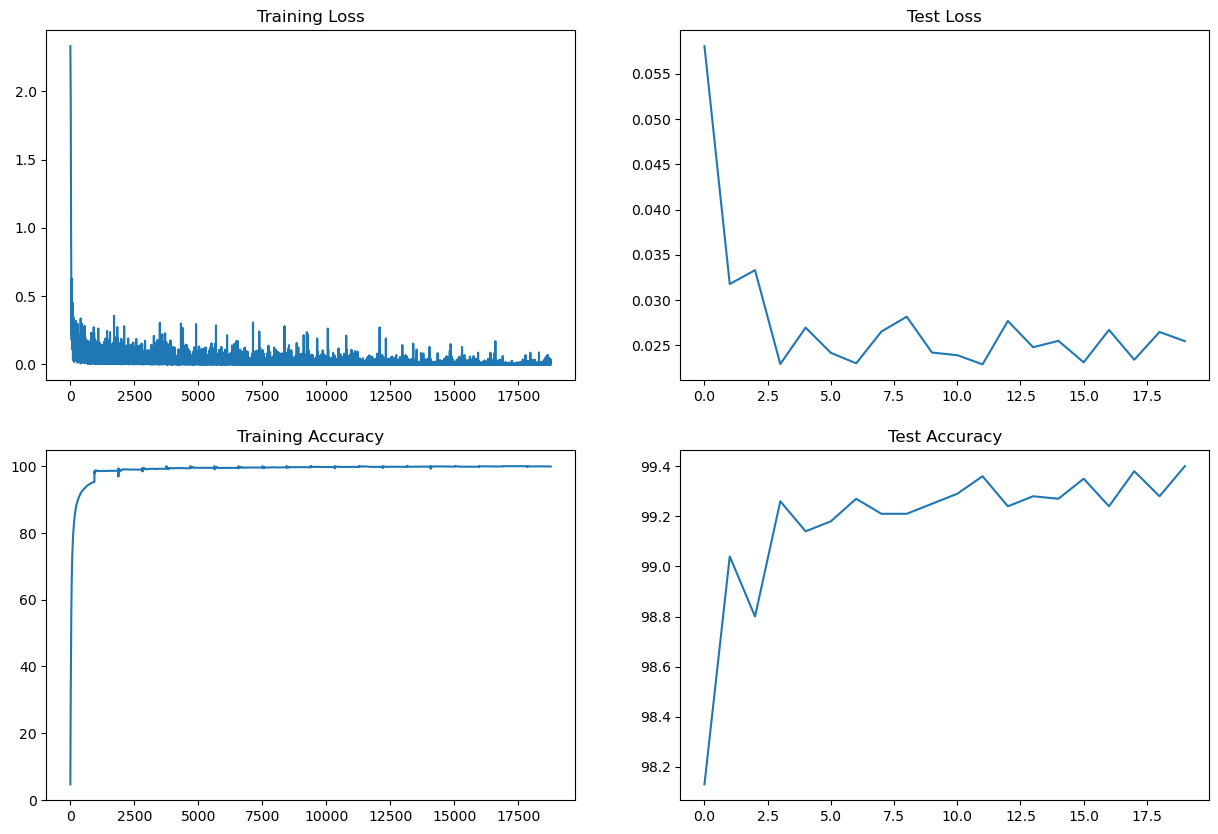

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
* Create a light weight model (Net3) with lesser paramerter than basic Model(Net2). <br>
* Introduce a Batch Normalization after every convolution layer (Conv2d->BN-Relu) except last 2 conv2d layers <br>
* Apply Max Pooling and Adaptive Average Pooling <br>
## Results:
* Parameters: 17k (17,354) <br>
* Best Training Accuracy: 99.98 <br>
* Best Test Accuracy: 99.40 <br>
## Analysis:
* Net3 is much roubust light weight model with 17k parameters that consistently produces test accuracy from ~ 99.25 to 99.4% range.<br>
* But the train model starts overfitting after it reached the max train accuracy of 99.98% and no further improvements is possible.<br>
* Need to add drop out and see the model performance <br>